In [1]:
import yfinance as yf
import numpy as np
import pyomo.environ as pyo

#### **EXTRACTING DATA**

In [3]:
#getting stocks data
tickers = ["ACES.JK", "ADRO.JK", "AKRA.JK",
           "AMRT.JK", "ANTM.JK", "ARTO.JK", "ASII.JK", "BBCA.JK",
           "BBNI.JK", "BBRI.JK", "BBTN.JK", "BMRI.JK", "BRIS.JK",
           "BRPT.JK", "CPIN.JK", "ESSA.JK", "EXCL.JK",
           "ICBP.JK", "INCO.JK", "INDF.JK", "INKP.JK",
           "INTP.JK", "ISAT.JK", "ITMG.JK", "JSMR.JK", "KLBF.JK",
           "MAPI.JK", "MDKA.JK", "MEDC.JK",
           "PGAS.JK", "PTBA.JK", "SIDO.JK", "SMGR.JK",
           "SMRA.JK", "TLKM.JK", "TOWR.JK", "UNTR.JK", "UNVR.JK"]

start = "2020-01-01"
end = "2025-01-01"
data0  = yf.download(tickers, start=start, end=end)
close0 = data0["Close"]
close0 = close0.dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  38 of 38 completed


In [4]:
monthly_close0 = close0.resample('ME').last()
returns0 = []
miuhat0 = []

for ticker in tickers:
    prices = monthly_close0[ticker].values
    logret = np.log(prices[1:] / prices[:-1]) * 100
    returns0.append(logret)
    miuhat0.append(np.mean(logret))

#### **CORRELATION FILETERING**

In [6]:
beta = [0.9, 0.95, 0.99, 0.9999]
threshold = [0.2, 0.5, 0.8]

In [7]:
def compute_cvar(returns, beta):
    losses = -returns
    N = len(losses)

    model = pyo.ConcreteModel()

    # Variables
    model.eta = pyo.Var()
    model.z = pyo.Var(range(N), domain=pyo.NonNegativeReals) 

    # Objective function
    model.obj = pyo.Objective(
        expr=model.eta + (1 / ((1 - beta) * N)) * sum(model.z[i] for i in range(N)),
        sense=pyo.minimize
    )

    # Constraints
    model.constraints = pyo.ConstraintList()
    for i in range(N):
        model.constraints.add(model.z[i] >= losses[i] - model.eta)
        model.constraints.add(model.z[i] >= 0)

    # Solve with GLPK
    solver = pyo.SolverFactory("glpk")
    result = solver.solve(model, tee=False)

    eta_val = pyo.value(model.eta)
    cvar_val = eta_val + (1 / ((1 - beta) * N)) * sum(pyo.value(model.z[i]) for i in range(N))

    return cvar_val

In [8]:
def compute_csr(returns, beta):
    miuhat = np.mean(returns)
    cvar_val = compute_cvar(returns, beta)
    if cvar_val != 0:
        csr_val = miuhat / cvar_val
    else:
        csr_val = np.nan  # avoid division by zero
    return csr_val

In [9]:
def correlation_filter(returns_list, tickers, beta, threshold):
    # Step 1 — Compute CSR for each asset
    csr_values = []
    for j in range(len(tickers)):
        csr_val = compute_csr(returns_list[j], beta)
        csr_values.append(csr_val)
    
    # Step 2 — Compute correlation matrix
    returns_array = np.array(returns_list)
    corr_matrix = np.corrcoef(returns_array)
    
    # Step 3 — Initialize list of assets to keep
    filtered_assets = tickers.copy()
    
    # Step 4 — Compare pairs below the main diagonal
    n = len(tickers)
    for i in range(1, n):
        for j in range(i):
            if corr_matrix[i, j] > threshold:
                if csr_values[i] >= csr_values[j]:
                    if tickers[j] in filtered_assets:
                        filtered_assets.remove(tickers[j])
                else:
                    if tickers[i] in filtered_assets:
                        filtered_assets.remove(tickers[i])
    
    return filtered_assets

In [10]:
stock_list = []
for b in beta:
    for t in threshold:
        filtered = correlation_filter(returns0, tickers, beta=b, threshold=t)
        stock_list.append(filtered)

In [11]:
for i in stock_list:
    print(i)
    print()

['ADRO.JK', 'AMRT.JK', 'BRIS.JK', 'SIDO.JK']

['ACES.JK', 'ADRO.JK', 'AKRA.JK', 'AMRT.JK', 'ARTO.JK', 'BBCA.JK', 'BRIS.JK', 'BRPT.JK', 'CPIN.JK', 'ESSA.JK', 'INDF.JK', 'ISAT.JK', 'KLBF.JK', 'MEDC.JK', 'SIDO.JK', 'TOWR.JK', 'UNVR.JK']

['ACES.JK', 'ADRO.JK', 'AKRA.JK', 'AMRT.JK', 'ANTM.JK', 'ARTO.JK', 'ASII.JK', 'BBCA.JK', 'BBRI.JK', 'BMRI.JK', 'BRIS.JK', 'BRPT.JK', 'CPIN.JK', 'ESSA.JK', 'EXCL.JK', 'ICBP.JK', 'INCO.JK', 'INDF.JK', 'INKP.JK', 'INTP.JK', 'ISAT.JK', 'ITMG.JK', 'JSMR.JK', 'KLBF.JK', 'MAPI.JK', 'MDKA.JK', 'MEDC.JK', 'PGAS.JK', 'PTBA.JK', 'SIDO.JK', 'SMGR.JK', 'SMRA.JK', 'TLKM.JK', 'TOWR.JK', 'UNTR.JK', 'UNVR.JK']

['ADRO.JK', 'AMRT.JK', 'BRIS.JK', 'SIDO.JK']

['ACES.JK', 'ADRO.JK', 'AKRA.JK', 'AMRT.JK', 'ARTO.JK', 'BBCA.JK', 'BRIS.JK', 'BRPT.JK', 'CPIN.JK', 'ESSA.JK', 'INDF.JK', 'ISAT.JK', 'KLBF.JK', 'MEDC.JK', 'SIDO.JK', 'TOWR.JK', 'UNVR.JK']

['ACES.JK', 'ADRO.JK', 'AKRA.JK', 'AMRT.JK', 'ANTM.JK', 'ARTO.JK', 'ASII.JK', 'BBCA.JK', 'BBRI.JK', 'BMRI.JK', 'BRIS.JK', 'BRPT.JK',

#### **MEAN-CVAR**

In [13]:
def mean_cvar(ticker_list, beta, start, end, n_points):
    # Step 1 — Download once
    data = yf.download(ticker_list, start=start, end=end, progress=False)
    close = data["Close"].dropna()
    monthly_close = close.resample('ME').last()

    # Step 2 — Compute returns and mean returns
    returns = []
    miuhat = []
    for ticker in ticker_list:
        prices = monthly_close[ticker].values
        sim_ret = ((prices[1:] / prices[:-1]) - 1) * 100
        returns.append(sim_ret)
        miuhat.append(np.mean(sim_ret))
    returns = np.array(returns)
    miuhat = np.array(miuhat)

    n_assets, n_periods = returns.shape
    Rtar_list = np.linspace(min(miuhat), max(miuhat), n_points)

    CVaR_list = []
    Rp_list = []
    weight_list = []

    # Step 3 — Loop through all target returns
    for Rtar in Rtar_list:
        # Pyomo model
        model = pyo.ConcreteModel()
        model.w = pyo.Var(range(n_assets), domain=pyo.NonNegativeReals)
        model.eta = pyo.Var()
        model.z = pyo.Var(range(n_periods), domain=pyo.NonNegativeReals)

        # Objective function
        model.obj = pyo.Objective(
            expr=model.eta + (1 / ((1 - beta) * n_periods)) * sum(model.z[t] for t in range(n_periods)),
            sense=pyo.minimize
        )

        # Constraints
        model.cons = pyo.ConstraintList()
        model.cons.add(sum(model.w[i] for i in range(n_assets)) == 1)
        model.cons.add(sum(model.w[i] * miuhat[i] for i in range(n_assets)) >= Rtar)
        for t in range(n_periods):
            model.cons.add(model.z[t] >= -sum(model.w[i] * returns[i, t] for i in range(n_assets)) - model.eta)

        solver = pyo.SolverFactory("glpk")
        result = solver.solve(model, tee=False)

        if result.solver.status == pyo.SolverStatus.ok and result.solver.termination_condition == pyo.TerminationCondition.optimal:
            current_weights = [pyo.value(model.w[i]) for i in range(n_assets)]
            
            actual_Rp = sum(current_weights[i] * miuhat[i] for i in range(n_assets))
            
            CVaR_list.append(pyo.value(model.obj))
            Rp_list.append(actual_Rp)
            weight_list.append(current_weights)
    return [CVaR_list, Rp_list, weight_list,Rtar_list,min(miuhat),max(miuhat)]

In [14]:
#n_points = int(input("berapa banyak titik Portofolio Returns :"))
n_points = 100

In [15]:
weight_list = []
cvar_list = []
Rp_list = []
Rtar_list = []
min_list = []
max_list = []

In [16]:
index = 0
for b in beta:
    for t in threshold:
        # pick the correct stock subset for this beta and threshold
        filtered = stock_list[index]

        # run mean_cvar for this subset
        cvar, Rp, weight, Rtar, kecil, besar = mean_cvar(filtered, b, start, end, n_points)

        # store results
        weight_list.append(weight)
        cvar_list.append(cvar)
        Rp_list.append(Rp)
        Rtar_list.append(Rtar)
        min_list.append(kecil)
        max_list.append(besar)
        # move to next stock subset
        index = index + 1

In [17]:
print(min_list)
print(max_list)

[0.7012009657967817, -1.849632444130302, -1.849632444130302, 0.7012009657967817, -1.849632444130302, -1.849632444130302, 2.8077880359465746, -1.849632444130302, -1.849632444130302, 2.8077880359465746, -1.849632444130302, -1.849632444130302]
[5.737518502719425, 5.74734053234663, 5.74734053234663, 5.737518502719425, 5.74734053234663, 5.74734053234663, 5.74734053234663, 5.74734053234663, 5.74734053234663, 5.74734053234663, 5.74734053234663, 5.74734053234663]


#### **GRAPH**

In [19]:
import matplotlib.pyplot as plt

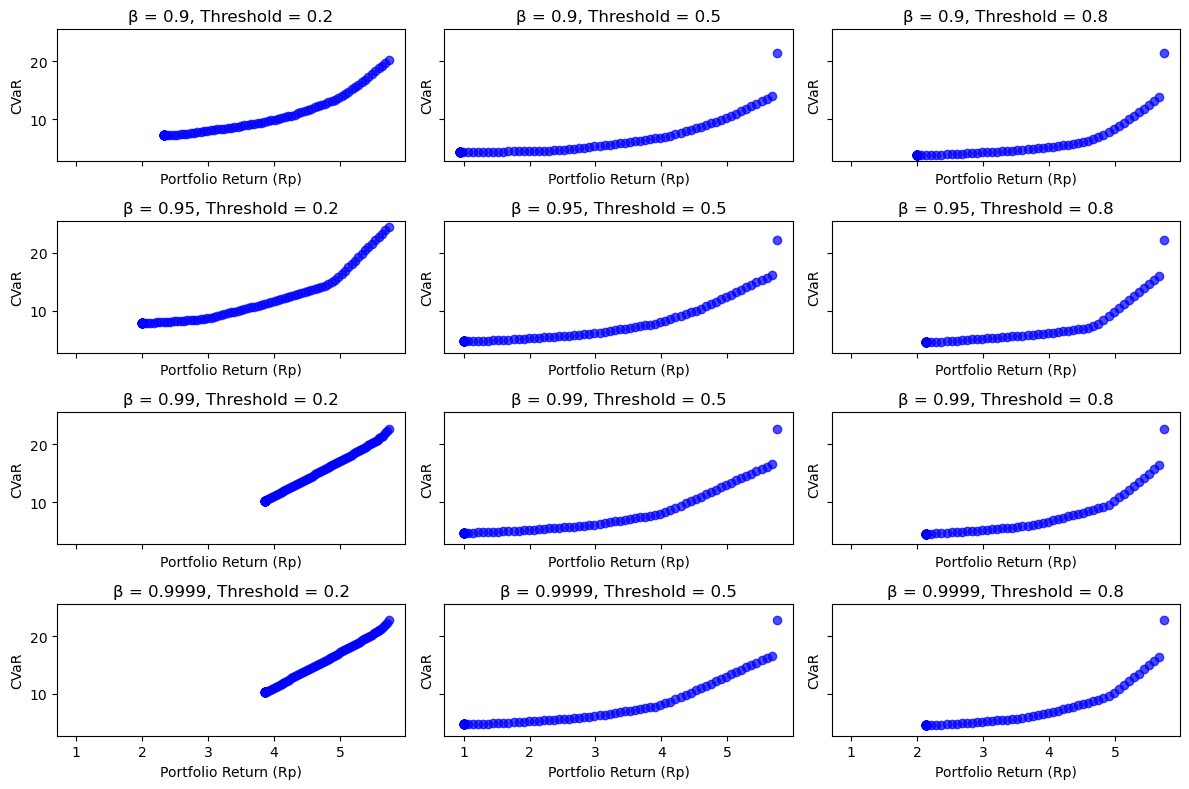

In [20]:
# Assuming beta, threshold, Rp_list, and cvar_list are already defined
fig, axes = plt.subplots(len(beta), len(threshold), figsize=(12, 8), sharex=True, sharey=True)

for i in range(len(beta)):
    for j in range(len(threshold)):
        index = i * len(threshold) + j  # match order of stock_list, Rp_list, etc.
        ax = axes[i, j]

        # Extract data for this combination
        Rp_vals = Rp_list[index]
        cvar_vals = cvar_list[index]

        # Scatter plot
        ax.scatter(Rp_vals, cvar_vals, color='blue', alpha=0.7)

        # Titles and labels
        ax.set_title(f"β = {beta[i]}, Threshold = {threshold[j]}")
        ax.set_xlabel("Portfolio Return (Rp)")
        ax.set_ylabel("CVaR")

plt.tight_layout()
plt.show()

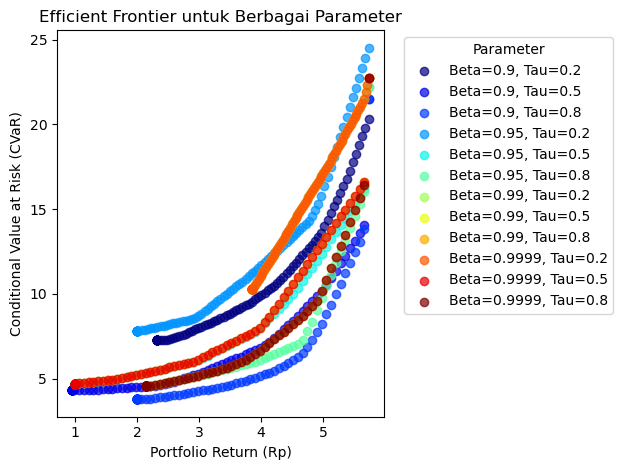

In [21]:
fig, ax = plt.subplots()

# --- Perubahan Dimulai Di Sini ---

# 1. Tentukan jumlah total kombinasi
num_combinations = len(beta) * len(threshold)

# 2. Buat palet warna unik sejumlah kombinasi tersebut.
#    Anda bisa ganti 'jet' dengan colormap lain seperti 'viridis', 'turbo', atau 'tab10'
colors = plt.get_cmap('jet')(np.linspace(0, 1, num_combinations))

# --- Loop Anda yang dimodifikasi ---

for i in range(len(beta)):
    for j in range(len(threshold)):
        index = i * len(threshold) + j  # Cocokkan dengan urutan list Anda
        Rp_vals = Rp_list[index]
        cvar_vals = cvar_list[index]
        
        # 3. Ambil warna dan buat label untuk legenda
        plot_color = colors[index]
        plot_label = f"Beta={beta[i]}, Tau={threshold[j]}" # (Saya asumsikan 'tou' adalah 'threshold')

        # 4. Gunakan 'color' dan 'label' yang baru
        ax.scatter(Rp_vals, cvar_vals, color=plot_color, alpha=0.7, label=plot_label)

# 5. Tambahkan legenda untuk menampilkan label
#    (bbox_to_anchor menempatkan legenda di luar plot agar tidak menutupi)
ax.legend(title="Parameter", bbox_to_anchor=(1.04, 1), loc="upper left")

# Menambahkan label dari kode Anda sebelumnya
ax.set_title("Efficient Frontier untuk Berbagai Parameter")
ax.set_xlabel("Portfolio Return (Rp)")
ax.set_ylabel("Conditional Value at Risk (CVaR)")

# Gunakan tight_layout() atau constrained_layout()
plt.tight_layout()
plt.show()